In [1]:
# 添加搜索路径
import sys
sys.path.insert(0, "/root/mounted/projects/qpair/")

In [2]:
import os
import pickle
import numpy as np
import time, datetime
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint, TensorBoard, LambdaCallback

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from config import * # 加载全局配置
from baselines import MODEL_WEM # 加载模型
from baselines import MODEL_WEM_ATTENTION
from baselines import MODEL_WEM_LSTM

MODEL_WEIGHTS_FILE = './keras_saved_models/baseline_model_wem_lstm.h5'

# # KN_PAIRS_SAMPLED_PATH = '/root/mounted/datasets/make_data/intermediate/'
# KN_PAIRS_SAMPLED_PATH = '/root/mounted/datasets/data_0521/intermediate/'
# KN_PAIRS_SAMPLED_PATH = '/root/mounted/datasets/data_0523/publish/'
KN_PAIRS_SAMPLED_PATH = '/root/mounted/datasets/publish_0606_tr50_v3.bak/'
# KN_PAIRS_SAMPLED_PATH = '/root/mounted/datasets/publish_mingwen_test/'
# KN_PAIRS_SAMPLED_PATH = '/root/mounted/datasets/publish_0606_tr50_test/'
# KN_PAIRS_SAMPLED_WIDS_CIDS_TRAIN_PKL = os.path.join(KN_PAIRS_SAMPLED_PATH, 'kn_train_test_pairs_sampled_wids_cids_train.pkl')
# KN_PAIRS_SAMPLED_WIDS_CIDS_TEST_PKL = os.path.join(KN_PAIRS_SAMPLED_PATH, 'kn_train_test_pairs_sampled_wids_cids_test.pkl')
KN_PAIRS_SAMPLED_WIDS_CIDS_TRAIN_PKL = os.path.join(KN_PAIRS_SAMPLED_PATH, 'intermediate/train.pkl')
KN_PAIRS_SAMPLED_WIDS_CIDS_TEST_PKL = os.path.join(KN_PAIRS_SAMPLED_PATH, 'intermediate/test.pkl')

TEST_LABEL_CSV = os.path.join(KN_PAIRS_SAMPLED_PATH, 'backend/test_label.csv')

VALIDATION_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 30
BATCH_SIZE = 1024

In [4]:
# 加载模型
model = MODEL_WEM()
# model = MODEL_WEM_ATTENTION()
# model = MODEL_WEM_LSTM()

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 39, 300)      6267600     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 39, 300)      6267600     input_2[0][0]                    
__________________________________________________________________________________________________
time_distr

In [6]:
# 加载数据集，并切分成train 和 validation
with open(KN_PAIRS_SAMPLED_WIDS_CIDS_TRAIN_PKL, 'rb') as f:
    kn_train_wids_cids_padded = pickle.load(f)

kn_train_wids_cids_padded.head()

,label,qid1,qid2,words1,words2,chars1,chars2
0,1,Q397345,Q538594,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0,Q193805,Q699273,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0,Q085471,Q676160,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0,Q189314,Q438123,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0,Q267714,Q290126,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
with open(KN_PAIRS_SAMPLED_WIDS_CIDS_TEST_PKL, 'rb') as f:
    kn_test_wids_cids_padded = pickle.load(f)

kn_test_wids_cids_padded

,qid1,qid2,words1,words2,chars1,chars2
0,Q017571,Q006012,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Q728241,Q542572,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Q166997,Q118270,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Q422420,Q514386,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Q354329,Q032485,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,Q438856,Q050667,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,Q635647,Q217357,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,Q466258,Q543640,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,Q244004,Q289633,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,Q332566,Q058858,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
test_label = pd.read_csv(TEST_LABEL_CSV)
test_label_orig = test_label.copy()
test_filter = test_label['is_preliminary'] < 2
test_is_pre = test_label['is_preliminary'] == 1
test_label = test_label[test_filter]

In [9]:
kn_test_wids_cids_padded_orig = kn_test_wids_cids_padded.copy()
kn_test_wids_cids_padded = kn_test_wids_cids_padded[test_filter]

In [10]:
# 暂时的
# kn_train_wids_cids_padded = pd.concat([kn_train_wids_cids_padded, kn_test_wids_cids_padded], ignore_index=True)

In [11]:
q1_inputs = kn_train_wids_cids_padded['words1'].values
q2_inputs = kn_train_wids_cids_padded['words2'].values
inputs = np.stack((q1_inputs, q2_inputs), axis=1)
labels = kn_train_wids_cids_padded['label']
inputs_train, inputs_val, labels_train, labels_val = train_test_split(inputs, labels, test_size=VALIDATION_SPLIT, random_state=RNG_SEED)
q1_train = np.array(list(inputs_train[:,0]))
q2_train = np.array(list(inputs_train[:,1]))
q1_val = np.array(list(inputs_val[:,0]))
q2_val = np.array(list(inputs_val[:,1]))

In [12]:
inputs_train.shape, inputs_val.shape

((228947, 2), (25439, 2))

In [13]:
np.array(list(q1_train)).shape

(228947, 39)

In [14]:
q1_test_inputs = np.array(list(kn_test_wids_cids_padded['words1'].values))
q2_test_inputs = np.array(list(kn_test_wids_cids_padded['words2'].values))
# labels_test = kn_test_wids_cids_padded['label']
labels_test = test_label.y_true

In [15]:
test_score = []
lambda_cb = LambdaCallback(on_epoch_end= lambda epock, logs: test_score.append(model.evaluate([q1_test_inputs, q2_test_inputs], labels_test, verbose=0)))

val_score = []
lambda_cb_val = LambdaCallback(on_epoch_end= lambda epock, logs: val_score.append(model.evaluate([q1_val, q2_val], labels_val, verbose=0)))

TENSORBORD_LOG_DIR = '/root/mounted/tensorboard/log'
try:
    shutil.rmtree(TENSORBORD_LOG_DIR)
except:
    pass

os.makedirs(TENSORBORD_LOG_DIR)
    

print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True),TensorBoard(log_dir=TENSORBORD_LOG_DIR), lambda_cb]
history = model.fit([q1_train, q2_train],
                    labels_train,
                    epochs=NB_EPOCHS,
#                     validation_data = ([q1_test_inputs, q2_test_inputs], labels_test),
                    validation_data = ([q1_val, q2_val], labels_val),
                    verbose=1,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2018-06-08 10:18:55.969854
Train on 228947 samples, validate on 25439 samples
Epoch 1/30
228947/228947 [==============================] - 5s 23us/step - loss: 0.6746 - acc: 0.6192 - val_loss: 0.5724 - val_acc: 0.7149
Epoch 2/30
228947/228947 [==============================] - 5s 20us/step - loss: 0.5403 - acc: 0.7398 - val_loss: 0.5159 - val_acc: 0.7614
Epoch 3/30
228947/228947 [==============================] - 5s 20us/step - loss: 0.4972 - acc: 0.7674 - val_loss: 0.4808 - val_acc: 0.7814
Epoch 4/30
228947/228947 [==============================] - 4s 19us/step - loss: 0.4687 - acc: 0.7829 - val_loss: 0.4539 - val_acc: 0.7952
Epoch 5/30
228947/228947 [==============================] - 5s 20us/step - loss: 0.4449 - acc: 0.7958 - val_loss: 0.4323 - val_acc: 0.8021
Epoch 6/30
228947/228947 [==============================] - 4s 19us/step - loss: 0.4247 - acc: 0.8059 - val_loss: 0.4145 - val_acc: 0.8110
Epoch 7/30
228947/228947 [==============================] - 5s 20us

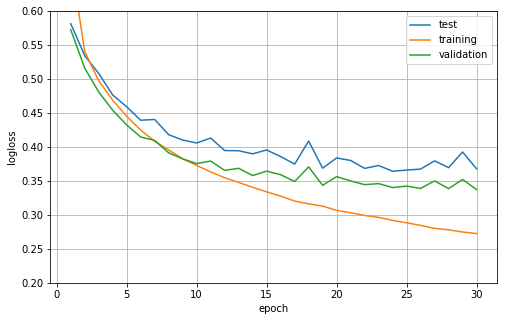

In [52]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['loss'],
                    'validation': history.history['val_loss'],
                    'test': np.array(test_score)[:,0], 
#                     'val': np.array(val_score)[:,0]
                   })
ax = acc.iloc[:,:].plot(x='epoch', figsize=(8,5), grid=True)
ax.set_ylabel("logloss")
ax.set_ylim([0.2,.6]);

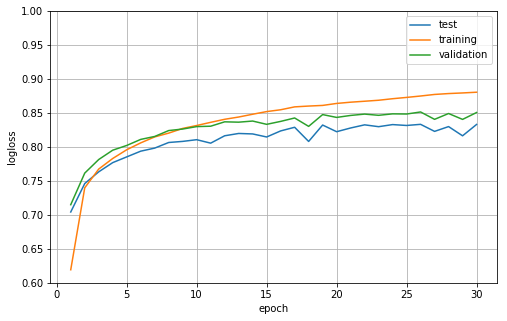

In [17]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['acc'],
                    'validation': history.history['val_acc'],
                    'test': np.array(test_score)[:,1], 
#                     'val': np.array(val_score)[:,1]
                   })
ax = acc.iloc[:,:].plot(x='epoch', figsize=(8,5), grid=True)
ax.set_ylabel("logloss")
ax.set_ylim([0.6,1]);

In [18]:
np.array(test_score)[:,0], len(test_score)

(array([0.5813599 , 0.53426585, 0.50811547, 0.47635873, 0.4590592 ,
        0.43924345, 0.4403426 , 0.41795615, 0.41011193, 0.40579547,
        0.4130152 , 0.39463383, 0.39434339, 0.38982138, 0.39547881,
        0.38578855, 0.3747113 , 0.40858406, 0.36873265, 0.38373738,
        0.38004283, 0.36843784, 0.37258266, 0.36419305, 0.36586045,
        0.36734304, 0.37949354, 0.36942929, 0.3925105 , 0.36780802]), 30)

In [19]:
# TEST_WIDS_CIDS_PADDED_PKL = os.path.join(INTERMEDIATE_DATA_PATH, 'test_clean_wids_cids_padded.pkl')
# with open(TEST_WIDS_CIDS_PADDED_PKL, 'rb') as f:
#     test_wids_cids_padded = pickle.load(f)
    
# test_wids_cids_padded

In [20]:
# q1_test_inputs = np.array(list(test_wids_cids_padded['words1'].values))
# q2_test_inputs = np.array(list(test_wids_cids_padded['words2'].values))
# test_labels = test_wids_cids_padded['label']
# q1_test_inputs.shape

In [21]:
# 直接用最后一个epoch的模型
model.load_weights(MODEL_WEIGHTS_FILE)
test_pred1 = model.predict([q1_test_inputs, q2_test_inputs], batch_size=BATCH_SIZE)
test_pred1 = test_pred1.squeeze()
test_pred1, test_pred1.shape

(array([0.21447986, 0.8937868 , 0.2793735 , ..., 0.38347423, 0.03146345,
        0.45151496], dtype=float32), (72956,))

In [22]:
test_pred1_df = pd.DataFrame({'y_pre':test_pred1})
test_pred1_df

,y_pre
0,0.214480
1,0.893787
2,0.279373
3,0.909336
4,0.708423
5,0.908546
6,0.116432
7,0.000065
8,0.983365
9,0.433836


In [23]:
TEST_PRED_1 = './predicts/test_pred1.csv'
test_pred1_df.to_csv(TEST_PRED_1, index=False)

In [24]:
model.load_weights(MODEL_WEIGHTS_FILE)
test_pred2 = model.predict([q1_test_inputs, q2_test_inputs], batch_size=BATCH_SIZE)
test_pred2 = test_pred2.squeeze()
test_pred2

array([0.21447986, 0.8937868 , 0.2793735 , ..., 0.38347423, 0.03146345,
       0.45151496], dtype=float32)

In [25]:
score = model.evaluate([q1_test_inputs, q2_test_inputs], labels_test)
score

72956/72956 [==============================] - 10s 135us/step


[0.36734303570452526, 0.8332008333888269]

In [26]:
from sklearn.metrics import log_loss
logloss = log_loss(labels_test, test_pred2, eps=1e-15)
logloss

0.36734303849174266

In [27]:
labels_val.sum()/labels_val.count()

0.5248633987185031

In [28]:
labels_test.sum()/labels_test.count()

0.5

In [29]:
labels_train.sum() / labels_train.count()

0.5184693400656047

In [30]:
temp = np.log(test_pred2)
np.argmin(test_pred2), test_pred2[np.argmin(test_pred2)], np.argmax(test_pred2), test_pred2[np.argmax(test_pred2)]

(57772, 4.942332e-08, 28178, 0.99991095)

In [31]:
type(labels_test)

pandas.core.series.Series

In [32]:
((labels_test * np.log(test_pred1_df.y_pre) + (1 - labels_test)  * np.log(1 - test_pred1_df.y_pre)) == - np.inf).sum()
y_pre = test_pred1_df.y_pre.map(lambda x: x if x >= 1e-15 else 1e-15)
one_plus_y_pre = 1 - y_pre
one_plus_y_pre = one_plus_y_pre.map(lambda x: x if x >= 1e-15 else 1e-15)

In [33]:
np.mean(-(labels_test * np.log(y_pre) + (1 - labels_test) * np.log(one_plus_y_pre)))

1.4593953120073941

In [34]:
a = np.ones(len(test_pred2))
a[0] = 0
log_loss(a, test_pred2, eps=1e-10)

1.853973471465613

In [35]:
temp = 1 - test_pred2
np.argmin(np.log(temp))

28178

In [36]:
np.log(temp)[37594]

-0.9561018

In [37]:
type(temp[37594])

numpy.float32

In [38]:
a = np.array([1,0,1], dtype=np.float64)
b = np.array([1, 1, 1], dtype=np.float32)
log_loss(a,b, eps=1e-10)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


nan

In [39]:
a = np.array(0, np.float32)

In [40]:
b = np.array(1e-15, dtype=np.float32)

In [41]:
a < b

True

In [42]:
q1_test_inputs_orig = np.array(list(kn_test_wids_cids_padded_orig['words1'].values))
q2_test_inputs_orig = np.array(list(kn_test_wids_cids_padded_orig['words2'].values))
labels_test_orig = test_label_orig.y_true

In [43]:
score = model.evaluate([q1_test_inputs_orig, q2_test_inputs_orig], labels_test_orig)
score

172956/172956 [==============================] - 6s 33us/step


[0.39131355196800677, 0.8248687527436063]

In [44]:
test_pred_orig = model.predict([q1_test_inputs_orig, q2_test_inputs_orig], batch_size=BATCH_SIZE)

In [45]:
test_pred_orig = test_pred_orig.squeeze()
test_pred_orig.shape

(172956,)

In [46]:
test_pred_orig_df = pd.DataFrame({'y_pre':test_pred_orig})
test_pred_orig_df.to_csv('./predicts/test_pred_orig.csv', index=False)

In [47]:
test_pred_orig_df = pd.read_csv('./predicts/test_pred_orig.csv')
test_pred_orig_df

,y_pre
0,0.214480
1,0.893787
2,0.279373
3,0.909336
4,0.251464
5,0.708423
6,0.908546
7,0.244653
8,0.116432
9,0.328250


In [53]:
# 带沙子
log_loss(test_label_orig.y_true, test_pred_orig_df.y_pre)

0.3913135576431491

In [49]:
# 初赛+复赛
log_loss(test_label.y_true, test_pred_orig_df[test_filter].y_pre)

0.36734303842786376

In [50]:
# 初赛
log_loss(test_label_orig[test_is_pre].y_true, test_pred_orig_df[test_is_pre].y_pre)

0.3671505968080204

In [51]:
test_is_pre.sum()

27358